# ARHMM Tutorial

## 1 What is an ARHMM?

Though HMMs are powerful probabilistic models, they are actually relatively constrained examples of more general graphical models like Bayesian networks or Markov random fields. While these generalizations are useful at times, their additional flexibility can dramatically increase the computational complexity of many algorithms. In some cases, exact calculations are intractable. Here we'll discuss one small extension of HMMs that can improve their ability to model correlations between emissions while still employing the same efficient algorithms.

In normal HMMs, the emission distributions depend only on the current state. Autoregressive HMMs (ARHMMs) make one small tweak to this structure by having the emission distributions depend on the current state **and** the previous emission. Graphically, if an HMM is represented by the typical lattice diagram shown below where boxes, circles, and arrows represent states, emissions, and probabilistic dependencies, respectively, then an ARHMM is equivalent to drawing an arrow from the previous emission to the current one.

![trellis](../assets/trellis.png)

## 2 Bull and Bear Markets

Let's introduce ARHMMs with an example from economics. First, though, we need to import Homomorph and some helper packages since we'll be using them shortly.

In [1]:
from itertools import product

import homomorph
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

### 2.1 Stock prices as autoregressive sequences

At any moment the stock price of a company is a record of its value when one unit last traded hands, and these prices reflect the feelings of the parties involved in the trade. Often these feelings are founded in evidence. For example, the latest earnings report may have showed strong growth and record profits. On other occasions, they're based on more emotional factors, like the sense that prices can only go up or the desire to [exact revenge](https://en.wikipedia.org/wiki/GameStop_short_squeeze) on a corrupt financial establishment. Regardless of their origin, these feelings determine prices, and sometimes the feelings are broadly optimistic. These occasions correspond to periods of sustained growth in prices known as a bull market. Other times there's doom and gloom on the horizon, the bear market takes hold, and prices fall.

We can make a simple model of this behavior using an ARHMM. ARHMMs are a good fit for the stock market because we expect the price tomorrow to not deviate too greatly from the price today. To phrase this idea more precisely, even though the jumps between days might follow a consistent distribution, we still need to know the previous day's price to correctly place the end point of each jump. To be clear, an ARHMM isn't *strictly* necessary under an assumption of identical and independently distributed (iid) jumps. It's also possible to pre-process observed data by taking differences between subsequent days. This yields a sequence of jumps that can be modeled by a largely equivalent HMM. (There are some minor differences in the treatment of the first emission.) Despite this, ARHMMs are the more powerful framework because they allow an end-to-end treatment of the data, *i.e.* no pre-processing, and do not require the simplifying assumption of iid jumps.

So far I've used the term jump loosely, suggesting they're calculated as a difference between subsequent days in the sense of a subtraction. This "additive" model is not the best fit to stock prices for two reasons. First, to allow prices to increase and decrease, we need to allow both positive and negative jumps. However, this may result in negative stock prices if there are too many jumps down when the price is low. Second, the perception of price is more closely tied to multiplication than addition. For example, a \\$10 stock gaining another \\$10 is much more significant than the same gain for a \\$1000 stock.

### 2.2 Geometric Brownian motion

The conventional "multiplicative" model of stock prices is called geometric Brownian motion and takes a specific form defined by the following stochastic differential equation:

$$ dX_t = \mu X_t dt + \sigma X_t dB_t $$

where $X_t$ is the stochastic process, $\mu$ is the drift, $\sigma$ is the volatility, and $B_t$ is a standard Brownian motion. The drift and volatility are constants which parametrize the average growth or decay of the process and its variation, respectively.

Don't worry too much about the exact meaning of this equation. Stochastic differential equations are an advanced topic often only covered in graduate probability courses. The important take-away for us is the value of the process changes according to both a deterministic and stochastic part. The deterministic part is proportional to $\mu$ and the current value of the process. The stochastic part is proportional to $\sigma$, the current value of the process, and a standard Brownian differential $dB_t$. Roughly speaking, a standard Brownian differential is a like small step sampled from a normal distribution, which is actually how we'll simulate it later.

Fortunately for us the previous equation has the analytic solution:

$$
X_t = X_0 \exp \left(
                     \left( \mu - \frac{\sigma^2}{2}
                     \right)t + \sigma B_t
                \right)
$$

where $X_0$ is the initial value of the process. This gives us an explicit formula for calculating the value of the process at any time. (Technically a standard Brownian motion is a continuous process, but we can generate a discrete analog by accumulating a sequence of normal variates.) As a quick note, the `ARHMM` generates simulations sequentially, so we take $t = 1$ in the above equation and generate one step at a time. This is equivalent to accumulating a sequence of normal variates which can be shown by expanding $X_t$ in terms of single steps.

We also need a expression for its pdf for some later calculations:

$$
f_{X_t}(x; \mu, \sigma, t)
=
\frac{1}{x \sigma \sqrt{2 \pi t}}
\exp{\left(-\frac{\left(\ln x - \ln X_0
                        - (\mu - \frac{1}{2} \sigma^2)t
                  \right)^2}
                 {2 \sigma^2 t}
     \right)}
$$

### 2.3 Instantiating the model

With the motivation and theory out of the way, let's actually build an ARHMM to model the price of a stock! If you've read the [HMM tutorial](https://github.com/marcsingleton/homomorph/blob/main/tutorials/hmm_intro.ipynb), most of what follows should be familiar. I'll focus exclusively on the features unique to the `ARHMM` class, so if you have any questions about the other arguments, please refer to the HMM tutorial.

The first difference is in the arguments of the methods of the emission distributions. Since they depend on the previous emission, we'll need to make some minor adjustments to the SciPy conventions. Unfortunately, this also means we can't directly use SciPy random variables, so we'll have to make a custom class. Although SciPy random variables implement many methods, the `ARHMM` class only uses the `rvs` and `pdf` or `pmf` methods, so we only need to supply those. Since the distributions also need to remember their parameters, we'll create a class that directly returns a "frozen" random variable.

In [2]:
class GBM_rv:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def rvs(self, x):
        d = self.mu - self.sigma ** 2 / 2
        s = self.sigma * stats.norm.rvs()
        return x * np.exp(d + s)
    
    def pdf(self, x):
        x0, x1 = x
        sigma2 = self.sigma ** 2
        c = 1 / (x1 * self.sigma * (2*np.pi) ** 0.5)
        n = (np.log(x1/x0) - self.mu + 0.5 * sigma2) ** 2
        d = 2 * sigma2
        return c * np.exp(-n / d)

To create the random variables for each state, we need to set their parameters. We can do this blindly, but it's actually a little tricky to choose them so the resulting sample paths look like plausible stock prices. The problem is $\mu$ and $\sigma$ are not direct measures of intuitive quantities like annual growth or the coefficient of variation. Fortunately with a small amount of work we can relate them.

Let's quickly review the equations for the expected value and variance of $X_t$ since we'll need them for our derivations.

$$
E(X_t) = X_0 e^{\mu t} \\
Var(X_t) = X_0^2e^{2 \mu t} \left(e^{\sigma^2 t} - 1 \right)
$$

A nice measure for the growth of an investment is the average annual growth rate (AAGR), which we can easily relate to $\mu$ from the equation for expected value.

$$
\begin{aligned}
E(X_{365}) &= X_0 e^{365 \mu} \\
\log \left( \frac{E(X_{365})}{X_0} \right) &= 365 \mu \\
\frac{\log \left( AAGR \right)}{365} &= \mu
\end{aligned}
$$

The variance is harder to think about since it's expressed in square units. A more intuitive quantity is the coefficient of variation (CV), which is the ratio of the standard deviation to the mean. We'll begin with deriving an equation for CV.

$$
\begin{aligned}
CV(X_t) &= \frac{\sqrt{Var(X_t)}}{E(X_t)} \\
&= \frac{\sqrt{X_0^2e^{2 \mu t} \left(e^{\sigma^2 t} - 1 \right)}}
        {X_0 e^{\mu t}} \\
&= \sqrt{e^{\sigma^2 t} - 1 }
\end{aligned}
$$

Now let's re-arrange this equation to express $\sigma$ in terms of the CV after one year.

$$
\begin{aligned}
CV(X_{365}) &= \sqrt{e^{365 \sigma^2} - 1 } \\
CV(X_{365})^2 + 1 &= e^{365 \sigma^2} \\
\sqrt{\frac{\log{CV(X_{365})^2 + 1}}{365}} &= \sigma
\end{aligned}
$$

With these equations in hand, we can now instantiate the emission distributions with some reasonable values.

In [3]:
aagr_bull = 1.075
aagr_bear = 0.90
cv_bull = 0.075
cv_bear = 0.085

mu_bull = np.log(aagr_bull) / 365
mu_bear = np.log(aagr_bear) / 365
sigma_bull = (np.log(cv_bull**2 + 1) / 365) ** 0.5
sigma_bear = (np.log(cv_bear**2 + 1) / 365) ** 0.5

GBM_bull = GBM_rv(mu_bull, sigma_bull)
GBM_bear = GBM_rv(mu_bear, sigma_bear)

The second difference is the `ARHMM` class requires a `start_e_dist` argument. As you just saw, we constructed the emission distributions to explicitly depend on the previous emission. However, the first emission doesn't have a previous emission, so the behavior in this case is undefined! The probabilistically principled approach would be to treat the previous emission as an unobserved variable and sum over all possible values to obtain a marginal distribution. For reasons of simplicity and flexibility, though, the `ARHMM` class asks you to explicitly provide a start emission distribution instead.

To keep things consistent, we'll make our stock prices always start at a constant value of 100. We can even imagine the company is about to IPO, and the finance team has set this as the initial price. SciPy doesn't provide a "constant" random variable, so we'll have to make it ourselves. As before, we need to define a class with `pdf` and `rvs` methods.

In [4]:
class constant_rv:
    def __init__(self, c):
        self.c = c
    
    def rvs(self):
        return self.c
    
    def pdf(self, x):
        if x == self.c:
            return 1
        else:
            return 0

Now that we've built all the pieces, let's put them together and instantiate an `ARHMM`! To spice things up a little, we'll make it random whether it starts in a bull or bear market. We won't be too cruel to our company, so we'll tilt the odds in favor of the bull market.

In [5]:
stock = homomorph.ARHMM(t_dists={'bull': {'bull': 0.999, 'bear': 0.001}, 'bear': {'bull': 0.005, 'bear': 0.995}},
                        e_dists={'bull': GBM_bull, 'bear': GBM_bear},
                        start_t_dist={'bull': 0.9, 'bear': 0.1},
                        start_e_dists={'bull': constant_rv(100), 'bear': constant_rv(100)},
                        name='AR Corp')
stock

ARHMM(states={'bear', 'bull'},
      stop_states=None,
      name='AR Corp')

### 2.4 Calculations with ARHMMs

If you've read the HMM tutorial, then you should be familiar with using the `HMM` class to simulate data and calculate various quantities. The `ARHMM` supports all the same operations, so I'll quickly demonstrate each. What follows largely serves as a test of the implementations, so I won't provide any context or explanation. If you have any questions, please refer to the HMM tutorial.

#### 2.4.1 Simulation

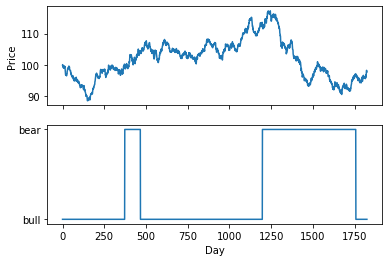

In [6]:
step_num = 365 * 5  # Five year projection
np.random.seed(12)
steps = stock.simulate(step_num)
states = [step[0] for step in steps]
emits = [step[1] for step in steps]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states)
axs[1].set_xlabel('Day')
axs[0].set_ylabel('Price');

#### 2.4.2 Emission sequence probability (forward algorithm)

In [7]:
fs, ss = stock.forward(emits)
print(fs['bull'][:5])
print(fs['bear'][:5])

[0.9, 0.9121911095143469, 0.8787823018154147, 0.8928112091471145, 0.8626714764416141]
[0.1, 0.08780889048565307, 0.12121769818458533, 0.10718879085288545, 0.1373285235583858]


#### 2.4.3 State inference (Viterbi algorithm)

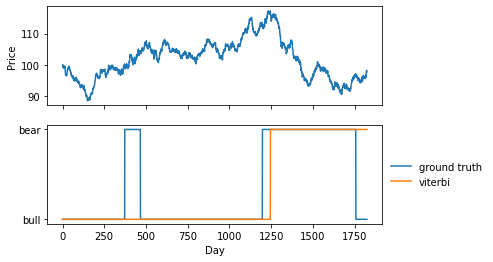

In [8]:
viterbi = stock.viterbi(emits)[0]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(viterbi, label='viterbi')
axs[1].set_xlabel('Day')
axs[0].set_ylabel('Price')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

#### 2.4.4 State inference (forward-backward algorithm)

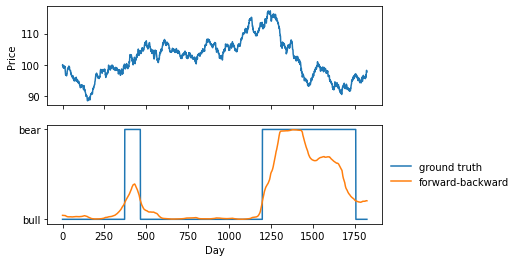

In [9]:
fbs = stock.forward_backward(emits)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(fbs['bear'], label='forward-backward')
axs[1].set_xlabel('Day')
axs[0].set_ylabel('Price')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

## 3 A coin flipping game

### 3.1 The rules of the game

I came across this next example while working with count data that was constrained by a maximum value. I won't try to provide any more context or motivation since my particular use case was so esoteric that explaining it would only confuse the topic and any other situation I could think up would be hopelessly artificial. The key point is the measurements were counting the number of elements in a set of a fixed size that had some property, a kind of data often modeled as a binomial random variable. I had reason to believe these counts had a certain amount of "momentum" and would be better described by an autoregressive model. Fortunately, autoregressive binomial models are described in various sources, but the formula for its pmf seemed to come out of nowhere until I came across this explanation. One of the reasons I like this example is its illustration of two points common in statistical modeling. First, it's not always immediately obvious how to construct a model with certain properties. Second, sometimes these unintuitive modeling problems have elegant solutions!

Enough introduction! Let's describe the coin flipping game. Imagine we have two biased coins, two corresponding cups, and a set of $n$ tokens. To start the game, we first randomly partition the tokens into the two cups by whatever rule we like. Each round is then played by flipping the two coins one time for each token in their respective cups. If the coin is heads, the token stays in that cup. If it's tails, it moves to the other cup.

That's the game! Clearly the total number of coins is fixed, so we need to designate one of the cups as the one of interest to make this a nontrivial variable. At the end of each round, we count the number of tokens in that cup and record the value as our observation. We then play as many times as we like. To see why this process creates an autoregressive binomial random variable, imagine the coin associated with the cup of interest is strongly biased towards heads. Once a token ends up in that cup, it will tend to stay there, creating a kind of "stickiness" in the counts from round to round.

### 3.2 Deriving the pmf

To do any calculations with this model, we need an expression for its pmf. First, though, since we're dealing with some kind of combination of binomial random variables, let's review the expression for their pmfs. If $X$ counts the number of "successes" out of $n$ trials where each trial has a probability $p$ of succeeding, then the probability of $i$ successes is given by:

$$ P(X = i) = {n \choose i} p^i(1-p)^{n-i} $$

At this point, reality departs somewhat from our coin flipping game. If we were actually observing this game, we could easily count of the number of heads flipped with each coin and calculate the probability of each with the above formula. The probability of the entire round is then just the product of these two numbers.

When it comes to real data, however, there are no coins and cups (or at least none that we actually observe). All we see at each time step is the number of successes. Fortunately, we can still use the model of the coin flipping game to derive an equation for the pmf. One of the difficulties in this case is we don't know which tokens came from which cup. If we did, we could simply take the product of probabilities of the two independent sets of flips as mentioned previously. Fortunately, many problems in probability can be solved by assuming you know what you don't and handling the uncertainty introduced by this assumption later. This technique is formally called *conditioning*.

In our case, let's call the number of tokens in the cup of interest at a time step $t$ as $X_t$. If there were previously $i$ tokens in the cup, we want to know the probability there will be $j$ tokens in the cup at the end of the current round. This is expressed mathematically as $P(X_t = j | X_{t-1} = i)$.

Now let's assume $c$ heads came up when we flip for the cup of interest. This means that $j - c$ heads came up when we flipped for the other cup since the two must sum to $j$. This is now just a case of calculating the probability of the flips for the other cup since everything else is given! To formalize this a little more, let's designate the number of heads for the cup of interest as a new random variable $C_0$ and the same quantity for the other cup as $C_1$. We'll also let $p_0$ and $p_1$ be the probabilities of success for the respective coins as well. Writing the previous discussion mathematically yields:

$$
\begin{aligned}
P(X_t = j | X_{t-1} = i, C_0 = c) &= P(C_1 = j-c) \\
&= {{n-i} \choose {j-c}} p_1^{j-c}(1-p_1)^{n-i-j+c}
\end{aligned}
$$

Now we'll use a fact about probability to deal with our assumption that $C_0 = c$. The following is true for any random variables $X$, $Y$, and $Z$:

$$
P(X = x | Y = y) = \sum_z P(X = x | Y = y, Z = z)P(Z = z)
$$

Applying this to our equation yields:

$$
P(X_t = j | X_{t-1} = i) = \sum_c
    \left[ {{n-i} \choose {j-c}} p_1^{j-c}(1-p_1)^{n-i-j+c} \right]
    \left[ {i \choose c} p_0^c(1-p_0)^{i-c} \right]
$$

where $c$ varies from $\max(0, i + j - n)$ to $\min(i, j)$.

Often the hardest part of these derivations is setting the bounds of the summation correctly, so let's review them quickly. We'll start with the upper bound. Imagine all tokens in the cup of interest at the end of the current round remained there from the previous round. This clearly cannot be larger than $j$, and conservation of the number of tokens means it also cannot exceed $i$. As for the lower bound, we can set a hard limit of 0 in cases where all the tokens came from the other cup. If $j$ exceeds this number, though, we'll have a deficit and some must come from the cup of interest. Since the number of tokens in the other cup is $n - i$, we can express this mathematically as $j - (n - i)$.

Recall this pmf is a function of both the previous and current number of tokens in the cup of interest, so we have two "free" variables, $i$ and $j$ in the resulting expression.

### 3.3 Instantiating the model

Let's now translate all this theory into some code! As with the stock market example we need to create a custom random variable to store its parameters, generate random variates, and calculate probabilities. For sake of demonstration, we'll make two emission distributions with different properties which we'll later use for different states in the ARHMM. I won't try to motivate the existence of these states other than stating they can model a counting variable that appears to operate under two different parameter regimes.

In [10]:
class ar1_binom_rv:
    def __init__(self, n, p0, p1):
        self.n = n
        self.p0 = p0
        self.p1 = p1
        
        # Pre-calculate pmf for all (i, j) pairs
        pmf = np.zeros((n+1, n+1))
        for i, j in product(range(n+1), range(n+1)):
            terms = []
            for c in range(max(0, i + j - self.n), min(i, j) + 1):
                t0 = stats.binom.pmf(c, i, self.p0)
                t1 = stats.binom.pmf(j - c, self.n - i, self.p1)
                terms.append(t0 * t1)
            pmf[i, j] = sum(terms)
        self._pmf = pmf
        
    def rvs(self, x):
        i = x  # Renamed for consistency with derivation
        js = np.arange(n+1)
        ps = self._pmf[i]
        rvs = stats.rv_discrete(values=(js, ps)).rvs()
        return rvs
    
    def pmf(self, x):
        i, j = x
        return self._pmf[i, j]


n = 30
e0 = ar1_binom_rv(n, 0.75, 0.5)
e1 = ar1_binom_rv(n, 0.99, 0.05)
es = [e0, e1]

Since these pmfs take two arguments, we can visualize the probabilities of various emission pairs with a heatmap.

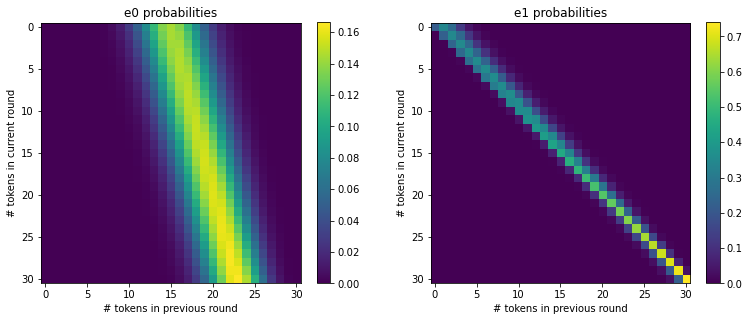

In [11]:
pmfs = [np.zeros((n+1, n+1)), np.zeros((n+1, n+1))]
for e, pmf in zip(es, pmfs):
    for i in range(n+1):
        for j in range(n+1):
            pmf[i, j] = e.pmf((i, j))

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))
for ax, pmf, label in zip(axs, pmfs, ['e0', 'e1']):
    im = ax.imshow(pmf)
    ax.set_title(f'{label} probabilities')
    ax.set_xlabel('# tokens in previous round')
    ax.set_ylabel('# tokens in current round')
    plt.colorbar(im, ax=ax)

In both cases, the emission pairs are limited to fairly tight "diagonals," indicating the counts can't jump too far from their previous values. However, the band in the first heatmap is much wider, which is a result of the higher variability of the two coins.

Let's now instantiate an ARHMM.

In [12]:
game = homomorph.ARHMM(t_dists={'e0': {'e0': 0.975, 'e1': 0.025}, 'e1': {'e0': 0.1, 'e1': 0.9}},
                       e_dists={'e0': e0, 'e1': e1},
                       start_t_dist={'e0': 1},
                       start_e_dists={'e0': stats.binom(n, 0.5)},
                       name='game')
game

ARHMM(states={'e1', 'e0'},
      stop_states=None,
      name='game')

### 3.4 Calculations with ARHMMs

We'll now run through the same kinds of calculations as demonstrated for the stock market example.

#### 3.4.1 Simulation

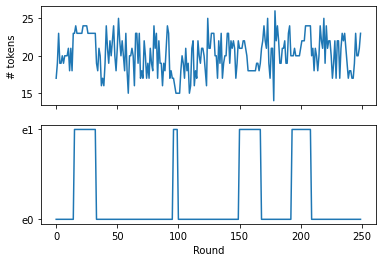

In [13]:
step_num = 250
np.random.seed(3)
steps = game.simulate(step_num)
states = [step[0] for step in steps]
emits = [step[1] for step in steps]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states)
axs[1].set_xlabel('Round')
axs[0].set_ylabel('# tokens');

#### 3.4.2 Emission sequence probability (forward algorithm)¶

In [14]:
fs, ss = game.forward(emits)
print(fs['e0'][:5])
print(fs['e1'][:5])

[1.0, 0.9842192892862528, 0.9993229872985384, 0.999988718065289, 0.9170684141265275]
[0.0, 0.01578071071374728, 0.0006770127014615365, 1.1281934711012073e-05, 0.08293158587347241]


#### 3.4.3 State inference (Viterbi algorithm)

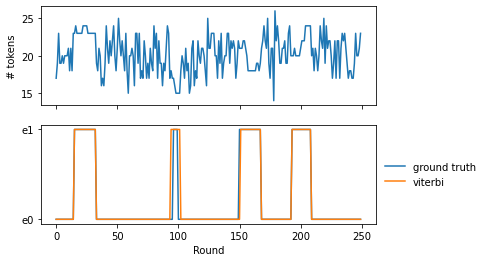

In [15]:
viterbi = game.viterbi(emits)[0]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(viterbi, label='viterbi')
axs[1].set_xlabel('Round')
axs[0].set_ylabel('# tokens')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

#### 3.4.4 State inference (forward-backward algorithm)

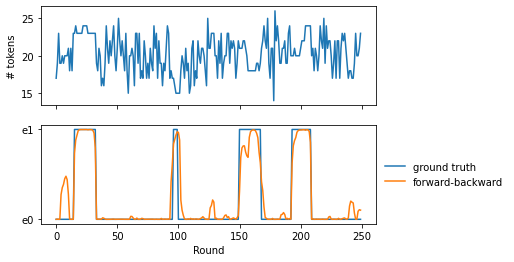

In [16]:
fbs = game.forward_backward(emits)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(fbs['e1'], label='forward-backward')
axs[1].set_xlabel('Round')
axs[0].set_ylabel('# tokens')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

## 4 Conclusion

This brings the tutorial on ARHMMs to a close. In summary, ARHMMs are closely related to normal HMMs, so the applications of the two are very similar. In fact, the implementation of the algorithms is virtually identical. There are, however, two major differences that the previous examples hopefully illustrated. First, the right autoregressive emission distribution isn't always immediately obvious and sometimes requires some theoretic or algebraic work to derive. Second, these emission distributions are rarely, if ever, available from established libraries and must be implemented as needed. Fortunately, once the theory is worked out, this is easy as directly translating some equations into code.